# Clustering Scifi Stories
I will scrape a number of short scifi stories for [Tor](tor.com), a book publisher.  I preprocess the texts with tokenizing, lemmatizing, and stop word removal. I create features with TF-IDF and do topic extraction. I try a number of clustering algorithms, and consider several metrics. 

### Instructions:

Pick texts: >100 entries, >10 authors, similar type of texts.

Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

### Instruction B
A. Start
1. Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.
2. Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.
3. You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

B.Things to keep in mind: 
4. how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?
Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.
5. Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.
6. You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.
7. Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

C. Be prepared to talk about:
1. Your end-user and the value your project provides to them.
1. Quantifiable results based on the research you’ve conducted.
1. The visuals you chose and what they represent for your research.
1. Next steps you'd take to expand on your work.
1. A specified research question your model addresses.
1. How you chose your model specification and what alternatives you compared it to.
1. The practical uses of your model for an audience of interest.
1. Any weak points or shortcomings of your model.


# Data Scraping

In [ ]:
import scrapy
import scrapy.crawler
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess({'AUTOTHROTTLE_ENABLED': True, # or download delay
                          'HTTPCACHE_ENABLED': True, # remove for final scrape to get live data
                          'ROBOTSTXT_OBEY': True, 
                          'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
                          'FEED_URI': 'sf_stories.csv',
                          'FEED_FORMAT': 'csv',
                          'FEED_EXPORT_ENCODING': '"utf-8"'})
class TorSpider(scrapy.Spider):
    name = 'tors'
    base_url = 'https://www.tor.com/category/all-fiction/original-fiction/page/{}'
    page = 1
    start_urls = [base_url.format(1), base_url.format(2)]] #first url lacks number
    def parse(self, response):
        for item in response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/@href"):
            item_url = response.urljoin(item.extract())
            yield scrapy.Request(item_url, callback=self.story)
        #if response.xpath("//*[@id='infinite-handle']/span/button").extract():
        #page = response.request.url[63:64] if response.request.url[63:].find('/') else response.request.url[63:65]
        page = response.request.url[63:(response.request.url[63:].find('/'))]
        if page == "":
            page = 1 
        page = int(page)
        page += 1
        yield scrapy.Request(self.base_url.format(page))
                                    
    def story(self, response):
        yield {'Title': response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/text()").extract(),
               'Author': response.xpath("//*[starts-with(@id,'post-')]/header/a/text()").extract(),
               #//*[@id="post-497584"]/div/p[7]
               'Body': response.xpath("//*[starts-with(@id,'post-')]/div/p/text()").extract()}


process.crawl(TorSpider)
process.start()

# Setup

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy.sparse import hstack

from nltk.tokenize import word_tokenize
# nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords as nltkstopwords
from nltk import bigrams

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.decomposition import PCA

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

#visualize
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.classifier import ROCAUC

In [118]:
#avoid warning due to missing glyphs for very high cluster numbers
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Exploration

In [119]:
stories_df = pd.read_csv('sf_stories.csv')

In [120]:
stories_df.head()

,Title,Author,Body
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...


In [121]:
stories_df.shape

(149, 3)

In [122]:
stories_df.Author.value_counts()

Rich Larson         4
Max Gladstone       3
Julianna Baggott    3
Jonathan Carroll    3
Carrie Vaughn       3
                   ..
Cory Doctorow       1
Marisela Navarro    1
Allen Steele        1
Ruthanna Emrys      1
Mimi Mondal         1
Name: Author, Length: 122, dtype: int64

In [123]:
stories_df["Author"].value_counts().value_counts()

1    102
2     14
3      5
4      1
Name: Author, dtype: int64

# Cleaning and Processing

In [124]:
stopwords = nltkstopwords.words('english')
punct = set(string.punctuation)
lem = WordNetLemmatizer()
def text_cleaner(text):
    text = text.lower()
    cleantext1 = " ".join(word for word in text.split() if word not in punct)
    cleantext2 = " ".join(word for word in cleantext1.split() if word not in stopwords)
    
    def lem_and_token(txt):
        '''tokenizes, and lemmatizes based on word position'''
        return [lem.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lem.lemmatize(i) \
                 for i, j in pos_tag(word_tokenize(txt))]

    cleantext3 = lem_and_token(cleantext2)
    return cleantext3

In [125]:
stories_df["tokenized_words"] = stories_df.Body.apply(text_cleaner)

In [126]:
stories_df.head()

,Title,Author,Body,tokenized_words
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ...","[war-torn, kurdistan, ,, group, traumatize, or..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...,"[vivian, daughter, witness, family, matriarch,..."
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...,"[man, can, ’, t, feel, pain, bioengineered, ki..."
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...,"[couple, concerned, dog, behaves, increasingly..."
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...,"[brand, new, story, mongolian, wizard, univers..."


In [127]:
#Create bigrams feature
stories_df["bgrams"] = stories_df.tokenized_words.apply(lambda x: list(bigrams(x)))

In [128]:
# term frequency-inverse document frequncy
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode')
#see if normalization is a param, else noramlize afterward

In [129]:
X_tfidf = vectorizer.fit_transform(stories_df.tokenized_words.apply(lambda x: " ".join(x)))

#### split into train/test

In [130]:
y = stories_df.Author
X_tfidf_tr, X_tfidf_te, y_train, y_test = train_test_split(X_tfidf, y, test_size=.25)

In [131]:
terms = vectorizer.get_feature_names()

# Clustering

In [132]:
# k-means++ givens evenly distributed starting pts
kmean = KMeans(n_clusters=10, init='k-means++', max_iter=200, n_init=100)
kmean.fit(X_tfidf_tr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=10, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [133]:
X_tfidf_norm = normalize(X_tfidf_tr.toarray())
X_tfidf_pca = PCA(2).fit_transform(X_tfidf_norm)

def visualize_clusters(model, name, Xpca=X_tfidf_pca, X=X_tfidf_tr):
    '''shows cluster on 2d plot of top 2 principal components'''
    y_pred = model.fit_predict(X)
    y_pred = pd.Series(y_pred).apply(lambda x: chr(x+97)) # stop sns using sequential color palette

    sns.set_style('darkgrid')
    sns.set_palette('deep')
    sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1], hue=y_pred)
    plt.title("Clusters from {}".format(name), fontsize=20);

In [134]:
class toarray_transformer(BaseEstimator, TransformerMixin):
    '''create transformers to include in clustering pipelines: to_array'''
    def __init__(self, ):
        super()
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X.toarray()

class cosine_distance_tform(BaseEstimator, TransformerMixin):
    '''create transformers to include in clustering pipelines: cosine dist'''    
    def __init__(self, ):
        super()
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return cosine_distances(X)

In [135]:
def elbow(model, modelname):
    inertia = []
    K = range(1,35)
    for i in K:
        md = model(n_clusters=i)
        md = md.fit(X_tfidf_norm)
        inertia.append(md.inertia_)
    sns.set_style("ticks")
    sns.lineplot(x=K, y=inertia, markers=True)
    plt.title(f"Elbow Chart for {modelname} Clusters")
    plt.ylabel("Sum of Squared Distance")
    plt.xlabel("Number of Clusters") ;

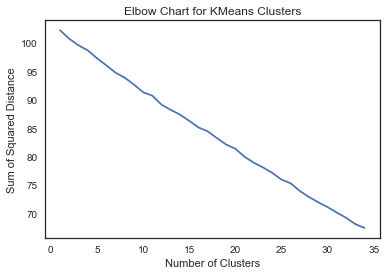

In [136]:
elbow(KMeans, "KMeans")

This elbow chart...doesn't elbow. The high distances are likely due to high dimensionality of the data. Kmeans is probably not the best clustering algorithm. Let's double check this with a different implementation of the elbow chart.

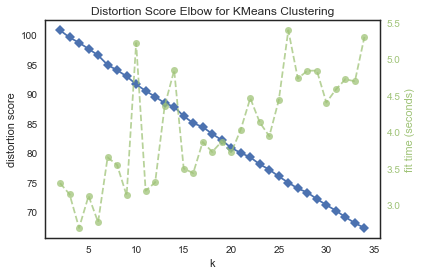

In [137]:
kmmodel = KMeans()
visualizer = KElbowVisualizer(kmmodel, k=(2,35), locate_elbow=False)
visualizer.fit(X_tfidf_tr)       
visualizer.poof();     

### k-means 
groups by randomly initiallizing starting centroids, measuring inertia (sum of square of distances from points to nearest centroids), and moving centroids to new central position, iterativly. Assumes isotropic clusters.

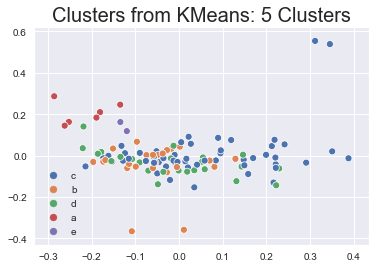

In [138]:
k_means5 = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=100)
visualize_clusters(k_means5, "KMeans: 5 Clusters");

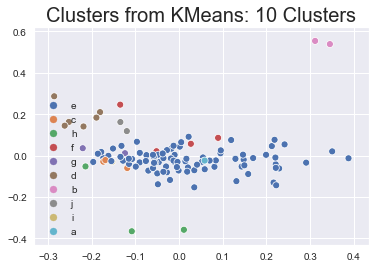

In [139]:
k_means10 = KMeans(n_clusters=10, init='k-means++', max_iter=200, n_init=100)
visualize_clusters(k_means10, "KMeans: 10 Clusters");

### DBSCAN 
(Density-based Spatial Clustering of Applications with Noise) groups based on contiguous minimum density. It finds core points based on points > minpts hyper, and within the eps distance. Core points are merged to or start new cluster. It does not depend on cluster shape.

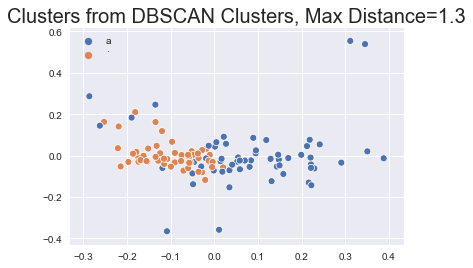

In [140]:
#DBSCAN was very sensitive to eps, 
#only small range of hypers worked to segment into a set of clusters with multiple points
DBs1 = DBSCAN(eps=1.3, min_samples=3)
visualize_clusters(DBs1, "DBSCAN Clusters, Max Distance=1.3");

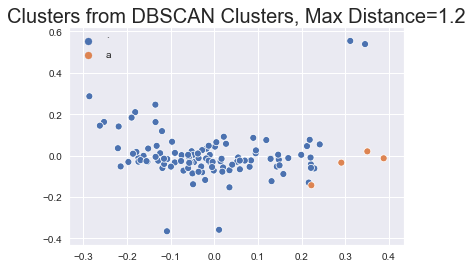

In [141]:
DBs2 = DBSCAN(eps=1.2, min_samples=3)
visualize_clusters(DBs2, "DBSCAN Clusters, Max Distance=1.2");

DBScan eps parameters outside of this range cause 0 clusters or clusters of 1. the minsamples has been reduced too.

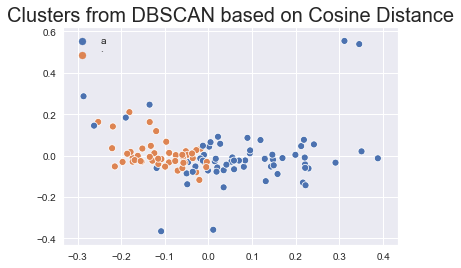

In [142]:
# DBSCAN with cosine similarity
DBs3cos = DBSCAN(eps=.85, metric='cosine', min_samples=3)
visualize_clusters(model=DBs3cos, name='DBSCAN based on Cosine Distance')

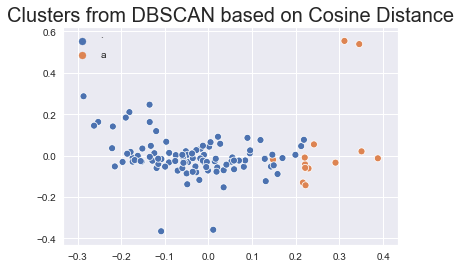

In [143]:
# DBSCAN with cosine similarity
DBs4cos = DBSCAN(eps=.75, metric='cosine', min_samples=3)
visualize_clusters(model=DBs4cos, name='DBSCAN based on Cosine Distance')

Trialing different eps gave several 1-group and remainder as singletons clustering options. This hyper gave a roughly 50-50 split visually.  
### Affinity Propogation
Based on how well exemplars can rerpesent datapoints. Begins with an nxn similarity matrix (n=number of observations), and repeatedly moves messages between two matrices: 'responsibility' of datapoints to be represented by exemplar vs other exemplars, and 'availibility', the appropriateness of representation of a point by an exemplar according to the exemplar.

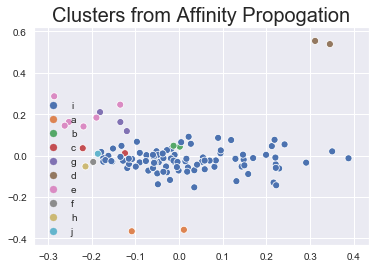

In [144]:
affprop1 = AffinityPropagation(damping=.5)
visualize_clusters(affprop1, "Affinity Propogation");

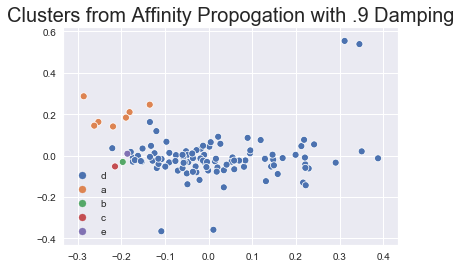

In [145]:
affprop2 = AffinityPropagation(damping=.9)
visualize_clusters(affprop2, "Affinity Propogation with .9 Damping");

### Agglomerative Clustering
Hierarchical clustering that merges 'closer' clusters. 
Average linkage uses average distance between all observations in two clusters to potentially merge.
Ward merges clusters based on minimizing variance.


In [146]:
agglom_ward = Pipeline(memory=None, steps=[('X_to_array', toarray_transformer()), 
                                           ('agglo_cluster', AgglomerativeClustering(linkage='ward', n_clusters=7))])

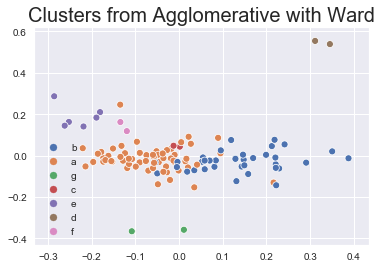

In [147]:
visualize_clusters(agglom_ward, "Agglomerative with Ward")

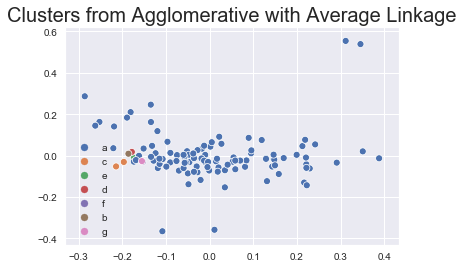

In [148]:
agglom_av = Pipeline(memory=None, steps=[('X_to_array', toarray_transformer()), 
                                           ('agglo_cluster', AgglomerativeClustering(linkage='average', n_clusters=7))])
visualize_clusters(agglom_av, "Agglomerative with Average Linkage")

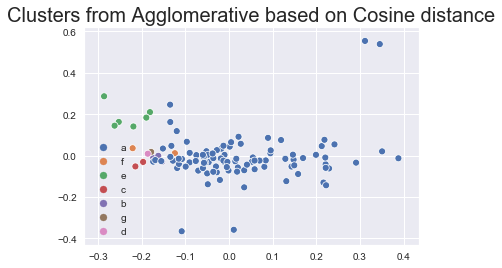

In [149]:
#todo add squareform()  to pipeline to moot clusterwarning
agglom_cos = Pipeline(memory=None, steps=[('X_to_cosine_distance', cosine_distance_tform()), 
                                           ('agglo_cos', AgglomerativeClustering(linkage='complete', 
                                                                                  affinity='precomputed',
                                                                                  n_clusters=7))])
visualize_clusters(agglom_cos, "Agglomerative based on Cosine distance")

### Spectral Clustering
Embeds an affinity matrix of the data into lower-dimension space before doing kmeans. I will use cosine distance because it is a way of standardizing distances.

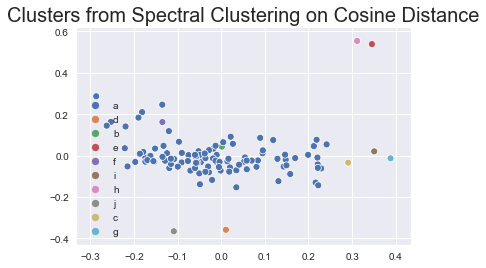

In [150]:
#based on eigenvalues/eigenvectors of similarity matrix for the records.
spectralcosine = Pipeline(memory=None, steps=[('X_to_cos_distance', cosine_distance_tform()), 
                                              ('Spectr_cluster', SpectralClustering(affinity='precomputed', n_clusters=10))])
visualize_clusters(spectralcosine, "Spectral Clustering on Cosine Distance")

### Mean Shift
Iteratively moves points down gradient of point density, as defined by the cumulative density of a kernel function for all points. The 'bandwidth' of the kernels controls the number of clusters; large (wide) bandwith creates fewer, larger clusters, and small bandwidth creates more local minima.

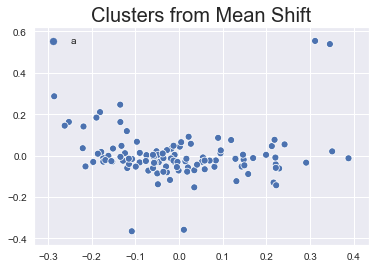

In [151]:
mean_shift = Pipeline(memory=None, steps=[('X_to_array', toarray_transformer()), 
                                          ('meanshift', MeanShift(bandwidth=1.5, cluster_all=False))])
visualize_clusters(mean_shift, "Mean Shift")

In a narrow bandwidth window, the clustering goes from 1 cluster to dozens.

## Compare Clusterings by Score

In [152]:
X1A, X3A, y1A, y3A = train_test_split(X_tfidf_tr, y_train, test_size=.5)
X1, X2, y1, y2 = train_test_split(X1A, y1A, test_size=.5)
X3, X4, y3, y4 = train_test_split(X3A, y3A, test_size=.5)
Xset= [X1, X2, X3, X4]

In [153]:
def sil_score(model, X_set=Xset, metric='euclidean'):
    score = []
    for sample in X_set:
        model = model.fit(sample)
        #if model is pipeline object, use secondary way to obtain label data
        try:
            labels = model.labels_
        except AttributeError:
            labels = model.steps[1][1].labels_
        score.append(silhouette_score(sample, labels, metric=metric))
    return score

In [154]:
model_list = {'k_means10': k_means10, 
              'k_means5': k_means5, 
              'affprop1': affprop1, 
              'affprop2': affprop2,
              'agglom_ward': agglom_ward, 
              'agglom_av': agglom_av, 
              'agglom_cos': agglom_cos,
              'mean_shift': mean_shift,
              'spectralcosine': spectralcosine
             }

In [155]:
cluster_score_df = pd.DataFrame(columns=["X1_euc", "X2_euc", "X3_euc", "X4_euc", "X1_cos", "X2_cos", "X3_cos", "X4_cos"])
for key, value in model_list.items():
    # low cluster numbers cause value errors, and this varies based on exact train/test split
    try:
        cluster_score_df.loc[key, :4] = sil_score(value, metric='euclidean')
    except ValueError:
        next

In [156]:
for key, value in model_list.items():
    try:
        cluster_score_df.loc[key, 4:] = sil_score(value, metric='cosine')
    except ValueError:
        next

In [157]:
cluster_score_df["euc_mean_score"] = cluster_score_df.loc[:,cluster_score_df.columns.str.endswith("_euc")].mean(axis=1)
cluster_score_df["cos_mean_score"] = cluster_score_df.loc[:,cluster_score_df.columns.str.endswith("_cos")].mean(axis=1)

In [158]:
for key, value in model_list.items():
    cluster_score_df.loc[key, "Adjusted_Rand"] = adjusted_rand_score(y_train, value.fit_predict(X_tfidf_tr))

In [159]:
cluster_score_df

,X1_euc,X2_euc,X3_euc,X4_euc,X1_cos,X2_cos,X3_cos,X4_cos,euc_mean_score,cos_mean_score,Adjusted_Rand
k_means10,0.0039077,0.0042424,0.00730595,0.00655438,0.00475181,0.00643143,0.0416152,0.0112922,0.005503,0.016023,0.002933
k_means5,0.0132607,0.0048803,0.0195271,0.00401041,0.0326705,0.0106947,0.0398738,0.00737412,0.010420,0.022653,0.001223
affprop1,0.0190595,0.0205984,0.0278013,0.00268712,0.0374021,0.040453,0.0541637,0.00497047,0.017537,0.034247,0.002365
affprop2,0.0190595,0.0205984,0.0278013,0.0163874,0.0374021,0.040453,0.0541637,0.032213,0.020962,0.041058,0.000810
agglom_ward,0.0105259,-0.00200599,0.0155679,0.00218267,0.0206477,-0.00422592,0.03012,0.00401096,0.006568,0.012638,0.006314
agglom_av,0.0155804,0.0109308,0.0235332,0.0146552,0.0306468,0.0214717,0.0458484,0.0288309,0.016175,0.031699,0.000825
agglom_cos,0.0155804,0.0102441,0.0219084,0.00843843,0.0306468,0.0201652,0.0427343,0.0166053,0.014043,0.027538,0.001967
spectralcosine,-0.0243876,-0.0282805,-0.0317823,-0.025526,-0.0491338,-0.0583045,-0.0742172,-0.048146,-0.027494,-0.057450,0.000043
mean_shift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


While some authors have multiple stories, the majority of the texts are one-offs. Thus, for an ideal Rand score, the clusters should be singletons for these authors. This may not be ideal for what we really want the clusters to be doing; we would choose classification if predicting who an author is were the goal.

In [160]:
agglom_ward_full = clone(agglom_ward)
agglom_ward_full.fit(X_tfidf)
aw_test_clusters = agglom_ward_full.fit_predict(X_tfidf_te)
print(f"Adjusted Rand Score on Test set is {adjusted_rand_score(y_test, aw_test_clusters)}.")

Adjusted Rand Score on Test set is -0.002839697098976109.


# Feature Extraction
lda cycles through each word in each document, recalculating probability that word belongs to particular 'topic' - set of words that can create a document, given probibility the document is associate with the topic the word currently is in.

In [161]:
lda = LatentDirichletAllocation(n_components=8, max_iter=10, learning_method='online',verbose=False)
lda.fit(X_tfidf)
lda_topics = lda.transform(X_tfidf)
lda.perplexity(X_tfidf)

93927649.37711465

In [162]:
svd = TruncatedSVD(n_components=8)
svd.fit(X_tfidf)
svd_topics = svd.transform(X_tfidf);

In [163]:
def topic_kwords(model, top_n=10, print_number=True):
    for topic_no, topic_name in enumerate(model.components_):
        print(f"Topic {topic_no}:")
        results = [(terms[i], topic_name[i]) for i in topic_name.argsort()[:-top_n - 1:-1]]
        print(results) if print_number else print([el[0] for el in results]) 

Latent Semantic Analysis: Lets use single value decomposition to create a alternate set of topics with keyword sets.
SVD turns the original mxn matrix into a set of matrices UΣV where U is the mxm feature matrix, Σ is the rectangular diagonal activation matrix of shape mXn and V is the weighting for original features. 

In [164]:
topic_kwords(lda, print_number=False )

Topic 0:
['tariq', 'hasan', 'sand', 'dune', 'mercifully', 'banking', 'coolly', 'pushcart', 'commentator', 'vibrancy']
Topic 1:
['jalopy', 'like', 'mei', 'cally', 'haziq', 'mar', 'know', 'terminal', 'say', 'mackenzie']
Topic 2:
['desk', 'evernight', 'pressboard', 'sultanate', 'focus', 'brainstorm', 'tantalizingly', 'china', 'spit', 'saga']
Topic 3:
['say', 'galo', 'king', 'princess', 'rhea', 'bo', 'alpnu', 'look', 'maria', 'like']
Topic 4:
['tiago', 'helen', 'like', 'vanessa', 'experiential', 'penny', 'paint', 'mechanically', 'awhile', 'principal']
Topic 5:
['say', 'like', 'know', 'look', 'make', 'come', 'time', 'think', 'don', 'hand']
Topic 6:
['vampire', 'say', 'thoughtless', 'boot', 'blade', 'mend', 'related', 'princess', 'nate', 'accurate']
Topic 7:
['talbot', 'camherst', 'cockatrice', 'mrs', 'sirs', 'mr', 'publication', 'si', 'hir', 'wilker']


In [165]:
topic_kwords(svd, print_number=False)

Topic 0:
['say', 'like', 'know', 'look', 'make', 'time', 'come', 'think', 'don', 'want']
Topic 1:
['persist', 'phrase', 'writer', 'tor', 'com', 'story', 'sf', 'persisted', '8th', 'moira']
Topic 2:
['helen', 'klaus', 'peter', 'felipe', 'cora', 'mimi', 'barchen', 'wong', 'persist', 'prasanna']
Topic 3:
['ollie', 'katyana', 'dad', 'mom', 'dylan', 'abyss', 'alien', 'persist', 'like', 'dog']
Topic 4:
['lake', 'ruby', 'jingru', 'ship', 'dan', 'water', 'ollie', 'creature', 'dr', 'moena']
Topic 5:
['ritter', 'ollie', 'katyana', 'sir', 'dylan', 'macdonald', 'dad', 'margrave', 'say', 'violet']
Topic 6:
['princess', 'prince', 'girl', 'ollie', 'father', 'katyana', 'dead', 'greta', 'circus', 'seonag']
Topic 7:
['mary', 'girl', 'george', 'dead', 'film', 'ruby', 'dino', 'rhea', 'lugosi', 'maria']


From matrices create features.

In [166]:
lda_topics_df = pd.DataFrame(lda_topics)
lda_topics_df.columns = [f"lda_topic{t}" for t in range(0,8)]
svd_topics_df = pd.DataFrame(svd_topics)
svd_topics_df.columns = [f"svd_topic{t}" for t in range(0,8)]
X_topics = pd.concat([lda_topics_df, svd_topics_df], axis=1)

In [167]:
agglom_ward

Pipeline(memory=None,
         steps=[('X_to_array', toarray_transformer()),
                ('agglo_cluster',
                 AgglomerativeClustering(affinity='euclidean',
                                         compute_full_tree='auto',
                                         connectivity=None,
                                         distance_threshold=None,
                                         linkage='ward', memory=None,
                                         n_clusters=7,
                                         pooling_func='deprecated'))],
         verbose=False)

In [168]:
ward_clusters = pd.Series(agglom_ward.fit_predict(X_tfidf))

# Classification

In [169]:
# create feature df from topic and clustering results
X_class = pd.concat([X_topics, ward_clusters.rename('ward_clus'), pd.DataFrame(X_tfidf.A)], axis=1)
X_class = pd.DataFrame(data=MinMaxScaler().fit_transform(X=X_class), columns=X_class.columns)

In [170]:
# small classes can't be classified. Will use two approaches: remove single-story-author's stories, and grouping them.
y_reduced = y[y.isin(y.value_counts()[y.value_counts() > 1].index)]
X_class_reduced = X_class[y.isin(y.value_counts()[y.value_counts() > 1].index)]
y_combined = y
y_combined[y.isin(y.value_counts()[y.value_counts() == 1].index)] = 'other_author'

In [171]:
#classifiers
logit = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=400)
nbayes = MultinomialNB()
nbayesc = ComplementNB()
KNNc = KNeighborsClassifier()

In [173]:
#cv each estimator on both version of dataset
cv_strat = StratifiedShuffleSplit(n_splits=2, test_size=.5)
estimators = {'logit': logit, 'KNN': KNNc, 'naive_bayes_multi': nbayes, 'naive_bayes_complement': nbayesc}
test_scores = pd.DataFrame(columns=['score'])
for est_name, est in estimators.items():
    test_scores.loc[est_name,'reduced_storyset_score'] = cross_validate(
        estimator=est, X=X_class_reduced, y=y_reduced, cv=cv_strat)['test_score'].mean()
    test_scores.loc[est_name,'combined_storyset_score'] = cross_validate(
        estimator=est, X=X_class, y=y_combined, cv=cv_strat)['test_score'].mean()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [185]:
test_scores

,score,reduced_storyset_score,combined_storyset_score
logit,NaN,0.229167,0.680000
KNN,NaN,0.104167,0.673333
naive_bayes_multi,NaN,0.187500,0.646667
naive_bayes_complement,NaN,0.437500,0.500000


On the reduced dataset of only stories by authors with multiple stories:  
Complement Naive Bayes (based on inverse of independent calculation of bayes theorem for each feature on  all _other_ classes) greatly outscored the other models. The out-of-box functionality is very helpful for a limited data set (most texts only had single author) which limited ability to do crossvalidated search for hyperparameters.  
When considering full dataset:  
The models look similar. Let's look at the results in more detail, with several metrics.

In [175]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_class_reduced, y_reduced, 
                                                                                    random_state=42, stratify=y_reduced, test_size=25)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_class, 
                                                                                        y_combined, random_state=42, 
                                                                                        stratify=y_combined, test_size=25)

In [178]:
y_pred_nbayesc_reduced = nbayesc.fit(X_train_reduced, y_train_reduced).predict(X_test_reduced)
f1_score(y_true=y_test_reduced, y_pred=y_pred_nbayesc_reduced, average='weighted')

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5573333333333333

In [179]:
y_pred_nbayesc_combined = nbayesc.fit(X_train_combined, y_train_combined).predict(X_test_combined)
f1_score(y_true=y_test_combined, y_pred=y_pred_nbayesc_combined, average='weighted')

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.4533333333333333

In [180]:
print(classification_report(y_true=y_test_combined, y_pred=y_pred_nbayesc_combined, output_dict=False))

                  precision    recall  f1-score   support

   Carrie Vaughn       0.00      0.00      0.00         1
  Dennis Danvers       0.00      0.00      0.00         0
       Greg Egan       0.50      1.00      0.67         1
    Hanuš Seiner       0.00      0.00      0.00         0
       Jo Walton       0.00      0.00      0.00         1
Jonathan Carroll       0.00      0.00      0.00         1
Julianna Baggott       0.00      0.00      0.00         1
    Lavie Tidhar       1.00      1.00      1.00         1
Margaret Killjoy       0.00      0.00      0.00         0
   Max Gladstone       0.50      1.00      0.67         1
Michael Swanwick       0.00      0.00      0.00         0
     Rich Larson       0.33      1.00      0.50         1
      S.B. Divya       0.00      0.00      0.00         0
    other_author       0.64      0.41      0.50        17

        accuracy                           0.44        25
       macro avg       0.21      0.32      0.24        25
    weighted

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [181]:
print(classification_report(y_true=y_test_reduced, y_pred=y_pred_nbayesc_reduced, output_dict=False))

                     precision    recall  f1-score   support

    Brooke Bolander       0.00      0.00      0.00         1
      Carrie Vaughn       0.00      0.00      0.00         2
Charlie Jane Anders       0.00      0.00      0.00         1
     Dennis Danvers       1.00      1.00      1.00         1
          Greg Egan       1.00      1.00      1.00         1
       Hanuš Seiner       0.50      1.00      0.67         1
            JY Yang       0.00      0.00      0.00         1
          Jo Walton       0.00      0.00      0.00         1
   Jonathan Carroll       0.67      1.00      0.80         2
   Julianna Baggott       1.00      0.50      0.67         2
       Lavie Tidhar       1.00      0.50      0.67         2
       Lettie Prell       1.00      1.00      1.00         1
   Margaret Killjoy       1.00      1.00      1.00         1
      Max Gladstone       0.25      1.00      0.40         1
   Michael Swanwick       1.00      1.00      1.00         1
        Rich Larson    

In [182]:
y_pred_logit_combined = logit.fit(X_train_combined, y_train_combined).predict(X_test_combined)
print(classification_report(y_true=y_test_combined, y_pred=y_pred_logit_combined, output_dict=False))

                  precision    recall  f1-score   support

   Carrie Vaughn       0.00      0.00      0.00         1
       Greg Egan       0.00      0.00      0.00         1
       Jo Walton       0.00      0.00      0.00         1
Jonathan Carroll       0.00      0.00      0.00         1
Julianna Baggott       0.00      0.00      0.00         1
    Lavie Tidhar       0.00      0.00      0.00         1
   Max Gladstone       0.00      0.00      0.00         1
     Rich Larson       0.00      0.00      0.00         1
    other_author       0.68      1.00      0.81        17

        accuracy                           0.68        25
       macro avg       0.08      0.11      0.09        25
    weighted avg       0.46      0.68      0.55        25



c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicting was more difficult with the single-text authors grouped in the class 'other', which is to be expected since this class doesn't necessarily have any internal commonality.  When considering the combined case, several models worked well by f1 score, but this is due to class imbalance; it just predicts the dominant class. Other metrics, like Macro average score, give a better picture of the results by giving equal importance to each class.

# Conclusion
Clustering was useful to find features in the very large original feature set that represent structure in those features. For the task of predicting a label, classification algorithms make the most sense. There was a wide divergence in the effectiveness of the classifiers tried. Clustering results could be useful on their own, for ex finding similar authors (stories in a cluster).